## UEFA 2019 클럽 데이터 (3월 초 수집 데이터)로 본 우승확률 예측

- UEFA에 진출한 클럽별 특징분석 및 시각화(PCA), 우승 확률 예측  
- 데이터가 31건에 불과한 전형적인 스몰데이터

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')

import missingno as msno

import warnings
warnings.filterwarnings('ignore')

### 데이터 읽기

In [56]:
uefa = pd.read_pickle('uefa_df.pkl')

#### 팀별로 경기수가 틀리다(6경기 또는 7경기 치름). 승률(WinsRate)을 추가하자(타겟피처)

In [58]:
uefa['WinsRate'] = uefa['Wins'] / uefa['Matches played']
uefa.iloc[[0,-1]]

,Matches played,Wins,Draws,Losses,Total goals,Average scored,Total goals against,Average conceded,Goal difference,Left foot,...,Fouls committed,Fouls suffered,Yellow cards,Red cards,Club,Wage_,Value_,Potential,Overall,WinsRate
0,7,5,1,1,19,2.71,8,1.14,11,8,...,91,61,12,1,Manchester City,219545.454545,5.363636e+07,89.818182,86.818182,0.714286
30,6,0,0,6,2,0.33,13,2.17,-11,0,...,81,59,15,2,AEK Athens,1000.000000,5.076923e+06,78.000000,73.642857,0.000000


---
### 데이터 기초분석, 상관분석

In [59]:
uefa.info()  # 팀명인 Club피처를 제외하면 모두 수치형

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31 entries, 0 to 30
Data columns (total 44 columns):
Matches played                    31 non-null int64
Wins                              31 non-null int64
Draws                             31 non-null int64
Losses                            31 non-null int64
Total goals                       31 non-null int64
Average scored                    31 non-null float64
Total goals against               31 non-null int64
Average conceded                  31 non-null float64
Goal difference                   31 non-null int64
Left foot                         31 non-null int64
Right foot                        31 non-null int64
Header                            31 non-null int64
Other                             31 non-null int64
Own goals (for)                   31 non-null int64
Inside area                       31 non-null int64
Outside area                      31 non-null int64
Penalties                         31 non-null int64
Total att

모든 피처의 관측치 5개를 살펴보자

In [60]:
for i, col in enumerate(uefa.columns):
    print('#{0}:{1}\n'.format(i, uefa[col].head()))

#0:0    7
1    7
2    7
3    7
4    7
Name: Matches played, dtype: int64

#1:0    5
1    4
2    5
3    4
4    5
Name: Wins, dtype: int64

#2:0    1
1    2
2    1
3    3
4    0
Name: Draws, dtype: int64

#3:0    1
1    1
2    1
3    0
4    2
Name: Losses, dtype: int64

#4:0    19
1    19
2    16
3    15
4    14
Name: Total goals, dtype: int64

#5:0    2.71
1    2.71
2    2.29
3    2.14
4    2.00
Name: Average scored, dtype: float64

#6:0    8
1    9
2    7
3    5
4    6
Name: Total goals against, dtype: int64

#7:0    1.14
1    1.29
2    1.00
3    0.71
4    0.86
Name: Average conceded, dtype: float64

#8:0    11
1    10
2     9
3    10
4     8
Name: Goal difference, dtype: int64

#9:0    8
1    7
2    0
3    3
4    5
Name: Left foot, dtype: int64

#10:0    8
1    9
2    8
3    9
4    6
Name: Right foot, dtype: int64

#11:0    3
1    1
2    4
3    3
4    3
Name: Header, dtype: int64

#12:0    0
1    0
2    0
3    0
4    0
Name: Other, dtype: int64

#13:0    0
1    1
2    0
3    0
4    0


#### 요약 통계

In [61]:
num_cols = [col for col in uefa.columns[:20] if uefa[col].dtype in ['int64', 'float64']]
uefa[num_cols].describe()

,Matches played,Wins,Draws,Losses,Total goals,Average scored,Total goals against,Average conceded,Goal difference,Left foot,Right foot,Header,Other,Own goals (for),Inside area,Outside area,Penalties,Total attempts,Average per game,Attempts on target
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.0,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,6.516129,2.483871,1.645161,2.387097,9.290323,1.394194,8.838710,1.385806,0.451613,3.225806,4.516129,1.161290,0.0,0.129032,7.870968,1.129032,0.838710,89.903226,13.673548,31.483871
std,0.508001,1.630357,1.305077,1.498386,4.503284,0.606997,3.474639,0.618653,6.566779,2.860183,2.014464,1.267459,0.0,0.340777,3.862140,1.087564,1.098386,25.121511,3.179628,12.266135
min,6.000000,0.000000,0.000000,0.000000,2.000000,0.330000,4.000000,0.670000,-12.000000,0.000000,1.000000,0.000000,0.0,0.000000,2.000000,0.000000,0.000000,37.000000,6.170000,9.000000
25%,6.000000,1.000000,1.000000,1.000000,6.000000,1.000000,6.000000,0.860000,-4.000000,1.000000,3.000000,0.000000,0.0,0.000000,5.000000,0.000000,0.000000,72.500000,11.750000,23.500000
50%,7.000000,2.000000,1.000000,2.000000,8.000000,1.290000,8.000000,1.170000,1.000000,2.000000,4.000000,1.000000,0.0,0.000000,7.000000,1.000000,0.000000,83.000000,13.330000,30.000000
75%,7.000000,4.000000,2.500000,3.000000,12.000000,1.770000,11.500000,1.915000,5.000000,5.500000,5.000000,2.000000,0.0,0.000000,10.000000,1.500000,2.000000,108.500000,15.765000,41.500000
max,7.000000,5.000000,6.000000,6.000000,19.000000,2.710000,16.000000,2.670000,11.000000,9.000000,9.000000,4.000000,0.0,1.000000,15.000000,4.000000,3.000000,142.000000,20.290000,54.000000


_Other 피처는 값이 모두 0이다. 분석 제외 필요_

In [62]:
num_cols = [col for col in uefa.columns[20:] if uefa[col].dtype in ['int64', 'float64']]
uefa[num_cols].describe()

,Attempts off target,Attempts blocked,Attempts against woodwork,PA,PC,PC %,Average ball possession (%),Average ball possession (time),Total corners for,Average corners for,...,Crosses completed,Fouls committed,Fouls suffered,Yellow cards,Red cards,Wage_,Value_,Potential,Overall,WinsRate
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,...,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,3.100000e+01,31.000000,31.000000,31.000000
mean,35.935484,22.483871,2.096774,3338.645161,2833.677419,0.841613,0.501290,29.903226,33.225806,5.057742,...,25.322581,81.935484,78.096774,13.774194,0.645161,82124.351455,2.432030e+07,84.391611,80.921138,0.367896
std,9.949658,7.438060,2.055154,857.272246,834.596045,0.036615,0.062862,4.563294,10.585240,1.398041,...,9.181093,15.159014,15.412884,3.169749,0.709384,84789.620037,1.683989e+07,4.171711,4.515884,0.227198
min,17.000000,10.000000,0.000000,1931.000000,1465.000000,0.760000,0.370000,22.000000,15.000000,2.500000,...,12.000000,54.000000,47.000000,8.000000,0.000000,1000.000000,3.454545e+06,74.666667,71.714286,0.000000
25%,31.000000,17.500000,0.500000,2603.500000,2153.000000,0.815000,0.455000,27.000000,25.000000,4.000000,...,17.500000,72.000000,70.000000,11.000000,0.000000,18500.000000,1.038636e+07,81.583333,77.807692,0.166667
50%,33.000000,21.000000,2.000000,3222.000000,2669.000000,0.840000,0.500000,30.000000,32.000000,5.170000,...,25.000000,81.000000,75.000000,14.000000,1.000000,55818.181818,1.885714e+07,85.153846,80.818182,0.333333
75%,39.500000,28.000000,3.000000,3974.000000,3415.000000,0.870000,0.550000,32.500000,40.000000,5.710000,...,31.500000,90.500000,86.000000,16.000000,1.000000,136636.363636,3.995455e+07,87.772727,84.444056,0.571429
max,56.000000,40.000000,8.000000,5017.000000,4523.000000,0.900000,0.600000,39.000000,63.000000,9.000000,...,43.000000,111.000000,107.000000,21.000000,2.000000,300000.000000,5.663636e+07,90.454545,88.000000,0.714286


#### 결측치 체크

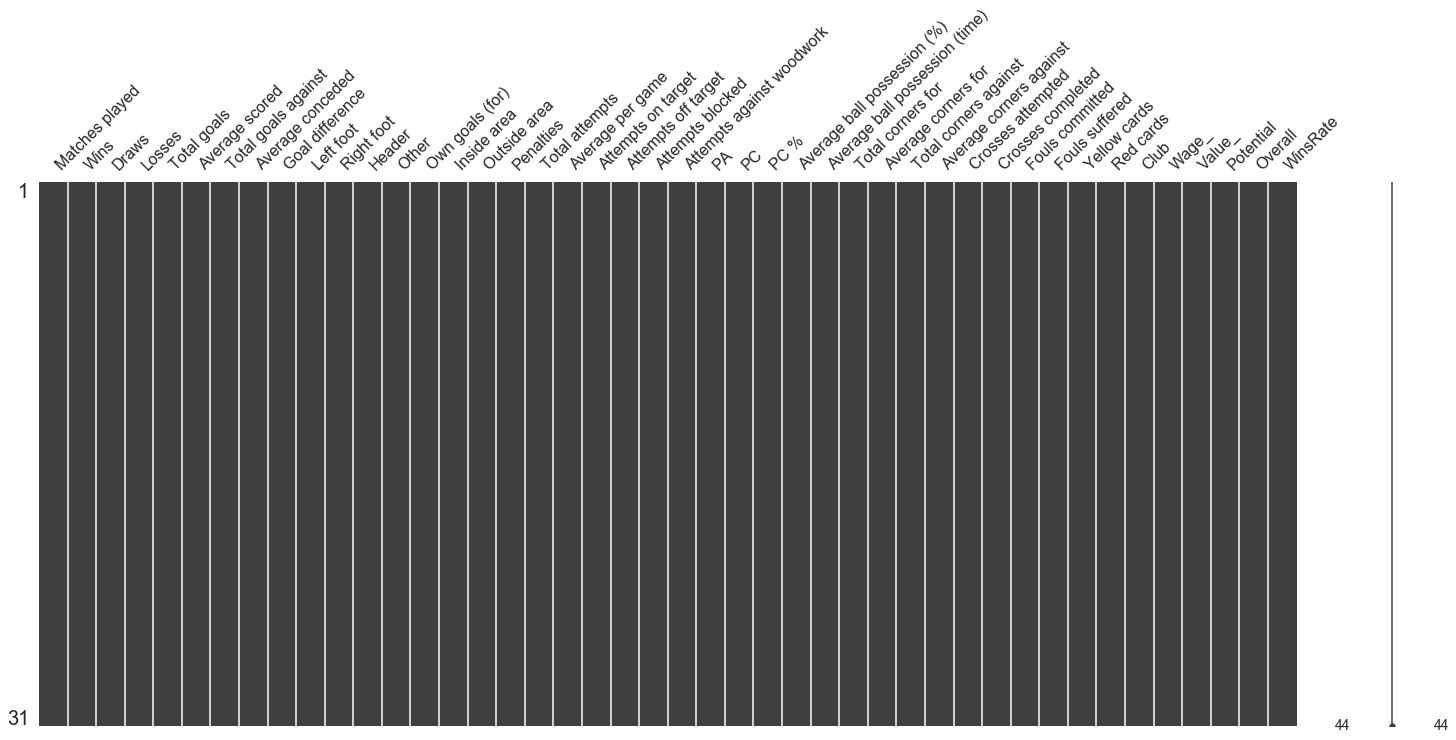

In [63]:
msno.matrix(uefa)

_모든 피처에서 결측치 없음_

#### 타겟피처인 승수(Wins), 승률(WinsRate) 분포보기

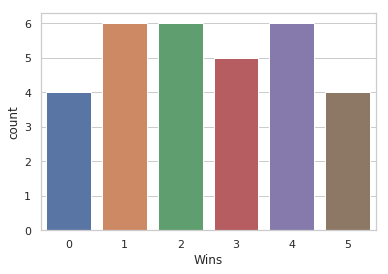

In [18]:
sns.countplot(uefa.Wins)

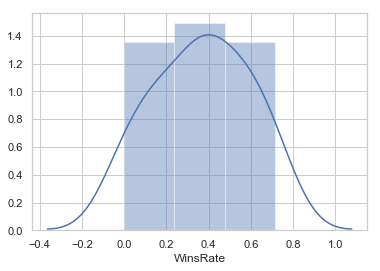

In [64]:
sns.distplot(uefa.WinsRate)  # ---> target 피처

#### 승수와 상관분석

In [7]:
uefa.corr()['Wins'].sort_values(ascending=False)

Wins                              1.000000
Goal difference                   0.860019
Matches played                    0.815323
PA                                0.771965
Inside area                       0.767260
Total goals                       0.761128
Average ball possession (%)       0.758027
PC                                0.753731
Overall                           0.744489
Value_                            0.742213
Average scored                    0.718022
Total corners for                 0.696525
Attempts on target                0.676298
Total attempts                    0.644132
Potential                         0.629386
Wage_                             0.628847
Right foot                        0.611578
Average ball possession (time)    0.602398
Average corners for               0.570259
PC %                              0.567218
Left foot                         0.561948
Crosses attempted                 0.548349
Average per game                  0.514904
Attempts of

- Other는 값이 모두 0이다. 제외하자.  
- 경기 중 승리(win)과 직접적인 영향이 있는 득점/실점 피처는 빠자 : Draws, Losses, Goal difference  
- 총 경기수도 빼자(6경기 또는 7경기인데, 7경기 치른팀 당연히 승수가 더 많음) : Matches played 
- Left foot, Right foot도 의미를 알 수 없는데, 승률과 비례함. 뺴자(오른쪽 골?)

#### 몇가지 피처 산점도 그려보기

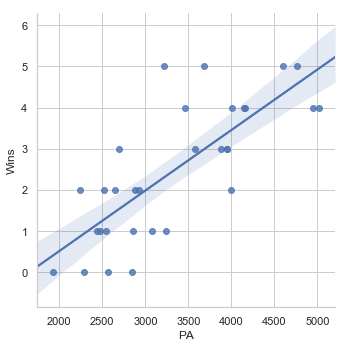

In [9]:
g = sns.lmplot(x='PA', y='Wins', data=uefa)   # PA: 패널티킥 시도 횟수

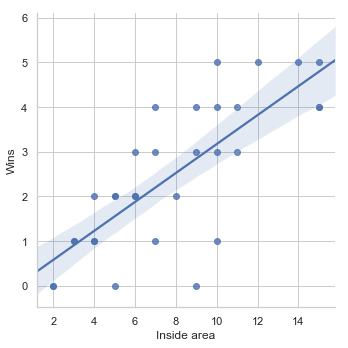

In [15]:
g = sns.lmplot(x='Inside area', y='Wins', data=uefa)

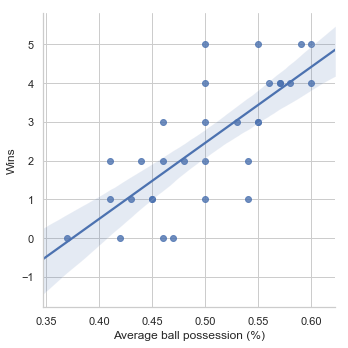

In [16]:
g = sns.lmplot(x='Average ball possession (%)', y='Wins', data=uefa)

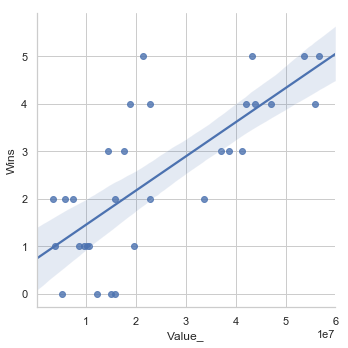

In [17]:
g = sns.lmplot(x='Value_', y='Wins', data=uefa)      # 클럽 선수별 가치 : 출처는...?

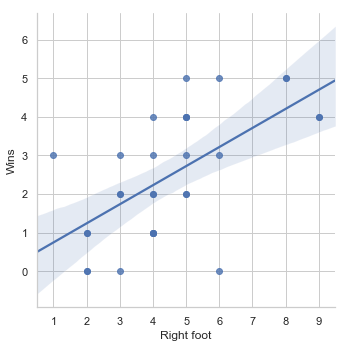

In [108]:
g = sns.lmplot(x='Right foot', y='Wins', data=uefa)   # Right foot : ????

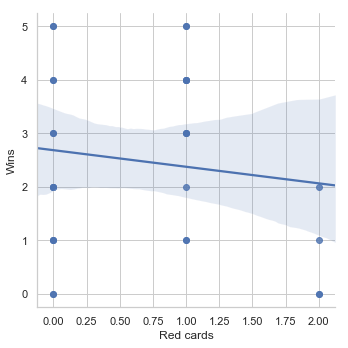

In [18]:
g = sns.lmplot(x='Red cards', y='Wins', data=uefa)

---
### 클럽별 특성 시각화

- PCA분석, 2차원 차트 구성

In [66]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

drop_cols = ['Other', 'Draws', 'Losses', 'Goal difference', 'Matches played', 'Left foot', 'Right foot']
uefa_df = uefa.drop(drop_cols, axis=1)

X = uefa_df.drop(['Club', 'Wins', 'WinsRate'], axis=1)
y = uefa_df['WinsRate']
club = uefa_df['Club']

X_norm = StandardScaler().fit(X).transform(X)   # 피처별로 스케일이 틀림. 반드시 표준화를 해 주어야 함

pca = PCA(n_components=10)                      # 주성분은 10개까지 뽑는다. 
pca.fit(X_norm)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

#### 스크리그래프(ScreePlot) : 주성분 중요도

[22.54183234  9.81437718  9.13270182  8.18358367  7.71124694  6.95738226
  6.13668572  5.20428225  4.9423905   4.24236609]


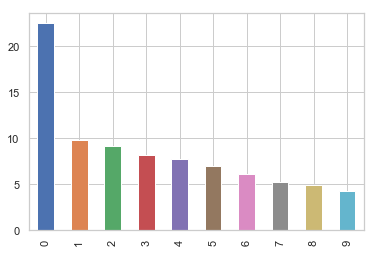

In [109]:
print(pca.singular_values_)
pd.Series(pca.singular_values_).plot(kind='bar')

_주성분 2부터는 중요도 조금씩 감소_

In [67]:
pca_results = pd.DataFrame(pca.components_.T)
pca_results.index = X.columns
pca_results.applymap('{:,.4f}'.format)

,0,1,2,3,4,5,6,7,8,9
Total goals,0.1965,0.0883,-0.2201,0.2598,0.1139,-0.0363,0.1507,-0.0110,-0.0406,0.0139
Average scored,0.1887,0.0957,-0.2471,0.2625,0.1124,-0.0207,0.1604,-0.0096,-0.0313,-0.0156
Total goals against,-0.1464,0.0116,-0.3075,-0.0167,-0.2418,0.1871,0.1111,-0.2207,0.3855,0.1518
Average conceded,-0.1626,0.0123,-0.2773,-0.0463,-0.2348,0.1931,0.1075,-0.1964,0.3648,0.1241
Header,0.0726,-0.1257,-0.4464,0.0768,0.1421,-0.2894,-0.0118,0.2122,0.1425,0.1207
Own goals (for),-0.0092,-0.0207,0.2498,0.3119,-0.3505,-0.2453,0.2278,0.0639,0.1144,0.3371
Inside area,0.1906,0.0535,-0.2061,0.2381,0.1781,-0.0850,0.1941,-0.0766,-0.0193,-0.0316
Outside area,0.1175,0.2151,-0.1821,0.2110,-0.0006,0.3196,-0.1286,0.3274,-0.0993,0.0510
Penalties,0.0365,-0.2827,0.0519,0.1816,0.4339,0.1599,-0.2230,-0.0951,-0.1011,0.2079
Total attempts,0.2249,-0.0526,-0.1065,0.0380,-0.1632,0.0690,-0.1500,-0.1344,-0.0605,-0.1035


PCA분석 결과 요약(PCA 1번, PCA 2번)  

- pca1 : 공격 지수(Total attempts, Average per game, Attempts on target, PA, PC, Average ball possession), 클럽 가치(Value, Wage,  Potential, Overall
- pca2 : 수비 지수(Fouls committed, ,Yellow cards, Red cards, Penalties, Attempts blocked, Average corners for, Crosses attempted, Crosses completed)

2차원 시각화

In [27]:
uefa_pca = pd.DataFrame(pca.fit_transform(X_norm))
uefa_pca = pd.concat([club, uefa_pca], axis=1)        # 클럽명 붙이기
uefa_pca

,Club,0,1,2,3,4,5,6,7,8,9
0,Manchester City,8.230150,-0.111432,-2.392458,0.065547,0.280780,1.873656,-0.436164,1.403533,0.296313,1.261008
1,Paris Saint-Germain,3.600410,2.440303,0.006574,3.808292,-0.910377,-1.017843,2.323123,-0.433657,0.527612,0.019136
2,FC Porto,0.092445,-0.303767,-1.516027,3.826357,2.949534,-1.248493,-0.687323,0.435267,-0.233709,0.535773
3,FC Bayern München,4.774809,-0.618718,-0.237895,-0.231639,2.690658,-0.783632,1.447228,-0.711935,0.469811,0.173178
4,Real Madrid,7.663115,-0.074899,-1.502557,-3.058900,-1.153818,-2.107222,0.341345,0.246745,-0.469279,-0.385209
5,FC Barcelona,7.241420,2.798725,0.913691,0.587692,-2.059486,2.545955,-1.087331,0.146899,-1.403390,-0.069605
6,Roma,1.548283,0.350822,-2.519255,-0.526844,0.058123,-0.921534,0.306353,-0.803499,-0.964568,-0.630829
7,Ajax,1.934052,-0.974204,1.227908,1.929536,0.804574,1.404595,-0.340809,-1.446566,-0.293707,-1.071566
8,Tottenham Hotspur,4.287784,-2.822291,-1.145865,-0.401639,-0.756786,-0.198710,0.758751,-0.210523,1.208499,0.568858
9,Olympique Lyonnais,-0.381818,2.725377,-1.400341,1.333741,-1.198112,0.148094,-1.542786,-0.248612,-0.327323,-0.070801


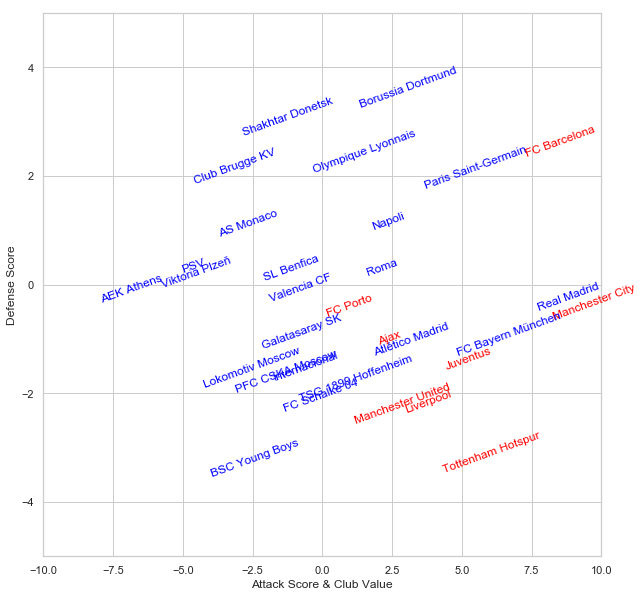

In [129]:
# 8강 진출팀은 붉은 글씨
quarterfinals = ['Manchester City', 'FC Porto', 'Juventus', 'FC Barcelona', 
                 'Liverpool', 'Manchester United', 'Ajax', 'Tottenham Hotspur']

fig = plt.figure(figsize=(10,10))

plt.xlim(-10, 10)
plt.ylim(-5, 5)

plt.xlabel('Attack Score & Club Value')
plt.ylabel('Defense Score')

for d in uefa_pca.iloc[:,:3].values:
    if d[0] in quarterfinals:
        plt.text(d[1], d[2], d[0], rotation=20, color='red')
    else:
        plt.text(d[1], d[2], d[0], rotation=20, color='blue')

_빨간색 폰트 클럽은 8강 진출팀이다._

_X축 값이 클수록 공격력이 강하고 클럽 가치가 높은 팀_  
_Y축은 수비 지수로, 값이 작을수록 파울수, 페널티, 옐로카드, 레드카드 등을 많이 받았다. 거친 플레이를 주로 했다고 해석하면 될 듯_  

_[참고] 수비 지수 값이 가장 작은 토트넘은 Fouls committed, Yellow cards, Red cards의 피처값이 클럽 평균보다 높다. 거친 플레이~!_ 

In [119]:
uefa[['Fouls committed', 'Yellow cards', 'Red cards']].mean()

Fouls committed    81.935484
Yellow cards       13.774194
Red cards           0.645161
dtype: float64

In [120]:
uefa.query("Club == 'Tottenham Hotspur'")[['Club', 'Fouls committed', 'Yellow cards', 'Red cards']]

,Club,Fouls committed,Yellow cards,Red cards
8,Tottenham Hotspur,111,16,1


---
### 우승확률 모델링

- 10개의 PCA 주성분을 가지고 지도학습을 진행한다.
- 타겟피처는 우승확률. 딥러닝모델과 회귀모델(ElasticNet)을 활용해보자.
- 타겟수가 31건 밖에 안되니, train/test는 분리하지 않는다. 

#### 1. DNN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

'''
# 데이터 몇개 없으니 분할하지 말고 돌려보자
X_train, X_valid, Y_train, Y_valid = train_test_split(uefa_pca.iloc[:,1:],   # X dataset
                                                      y, 
                                                      test_size=0.2)
'''

model = Sequential()
model.add(Dense(30, input_dim=10, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')  
model.fit(uefa_pca.iloc[:,1:], y, epochs=200, batch_size=10) 

# 전체 적용
y_pred_dnn = model.predict(uefa_pca.iloc[:,1:]).flatten()

#### 2. Regression(Elastic Net)

In [102]:
from sklearn.linear_model import ElasticNet

regr = ElasticNet()
regr.fit(uefa_pca.iloc[:,1:], y)
y_pred_regr = regr.predict(uefa_pca.iloc[:,1:])

_DNN과 Regression 결과물을 합치자_

In [103]:
uefa_pred = pd.concat([uefa_pca, 
                       pd.Series(y), 
                       pd.Series(y_pred_dnn),
                       pd.Series(y_pred_regr)], axis=1)
uefa_pred.columns = ['Club', 
                     'pca0', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9', 
                     'y_true', 'y_pred_dnn', 'y_pred_regr']
uefa_pred.sort_values(by='y_true', ascending=False)

,Club,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,y_true,y_pred_dnn,y_pred_regr
0,Manchester City,8.230150,-0.111432,-2.392458,0.065547,0.280780,1.873656,-0.436164,1.403533,0.296313,1.261008,0.714286,0.708224,0.470692
2,FC Porto,0.092445,-0.303767,-1.516027,3.826357,2.949534,-1.248493,-0.687323,0.435267,-0.233709,0.535773,0.714286,0.236667,0.369050
4,Real Madrid,7.663115,-0.074899,-1.502557,-3.058900,-1.153818,-2.107222,0.341345,0.246745,-0.469279,-0.385209,0.714286,0.711535,0.463610
10,Atlético Madrid,1.780970,-0.808243,0.985582,-0.585615,0.056047,-0.544426,1.947746,2.085890,0.231500,-1.714163,0.714286,0.715789,0.390140
12,Juventus,4.356396,-1.269275,1.325831,-1.080542,-0.650791,-0.144270,-1.443357,-1.043222,-0.818898,0.465711,0.571429,0.572314,0.422308
3,FC Bayern München,4.774809,-0.618718,-0.237895,-0.231639,2.690658,-0.783632,1.447228,-0.711935,0.469811,0.173178,0.571429,0.567785,0.427534
5,FC Barcelona,7.241420,2.798725,0.913691,0.587692,-2.059486,2.545955,-1.087331,0.146899,-1.403390,-0.069605,0.571429,0.567984,0.458343
6,Roma,1.548283,0.350822,-2.519255,-0.526844,0.058123,-0.921534,0.306353,-0.803499,-0.964568,-0.630829,0.571429,0.580303,0.387234
1,Paris Saint-Germain,3.600410,2.440303,0.006574,3.808292,-0.910377,-1.017843,2.323123,-0.433657,0.527612,0.019136,0.571429,0.236667,0.412866
11,Borussia Dortmund,1.284417,3.893727,2.202558,-1.631600,2.074458,-0.111396,1.170384,-0.435651,-0.159288,0.491030,0.571429,0.574851,0.383938


#### DNN 기준 우승확률 TOP 5

In [121]:
uefa_pred.sort_values(by='y_pred_dnn', ascending=False).iloc[:5]

,Club,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,y_true,y_pred_dnn,y_pred_regr
10,Atlético Madrid,1.780970,-0.808243,0.985582,-0.585615,0.056047,-0.544426,1.947746,2.085890,0.231500,-1.714163,0.714286,0.715789,0.390140
4,Real Madrid,7.663115,-0.074899,-1.502557,-3.058900,-1.153818,-2.107222,0.341345,0.246745,-0.469279,-0.385209,0.714286,0.711535,0.463610
0,Manchester City,8.230150,-0.111432,-2.392458,0.065547,0.280780,1.873656,-0.436164,1.403533,0.296313,1.261008,0.714286,0.708224,0.470692
6,Roma,1.548283,0.350822,-2.519255,-0.526844,0.058123,-0.921534,0.306353,-0.803499,-0.964568,-0.630829,0.571429,0.580303,0.387234
11,Borussia Dortmund,1.284417,3.893727,2.202558,-1.631600,2.074458,-0.111396,1.170384,-0.435651,-0.159288,0.491030,0.571429,0.574851,0.383938


#### Regression(ElasticNet) 기준 우승확률 TOP 5

In [122]:
uefa_pred.sort_values(by='y_pred_regr', ascending=False).iloc[:5]

,Club,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,y_true,y_pred_dnn,y_pred_regr
0,Manchester City,8.230150,-0.111432,-2.392458,0.065547,0.280780,1.873656,-0.436164,1.403533,0.296313,1.261008,0.714286,0.708224,0.470692
4,Real Madrid,7.663115,-0.074899,-1.502557,-3.058900,-1.153818,-2.107222,0.341345,0.246745,-0.469279,-0.385209,0.714286,0.711535,0.463610
5,FC Barcelona,7.241420,2.798725,0.913691,0.587692,-2.059486,2.545955,-1.087331,0.146899,-1.403390,-0.069605,0.571429,0.567984,0.458343
3,FC Bayern München,4.774809,-0.618718,-0.237895,-0.231639,2.690658,-0.783632,1.447228,-0.711935,0.469811,0.173178,0.571429,0.567785,0.427534
12,Juventus,4.356396,-1.269275,1.325831,-1.080542,-0.650791,-0.144270,-1.443357,-1.043222,-0.818898,0.465711,0.571429,0.572314,0.422308


_개인적으로는 Regression에 더 신뢰가 감!!!_

#### MSE값 비교

In [104]:
# DNN
mean_squared_error(uefa_pred['y_true'],
                   uefa_pred['y_pred_dnn'])

0.010992642492458692

In [105]:
# Regression(ElasticNet)
mean_squared_error(uefa_pred['y_true'],
                   uefa_pred['y_pred_regr'])

0.034750466918646354

_MSE는 DNN이 Regression보다 작다.(오차가 작음)_

#### 모델 적합 결과 차트

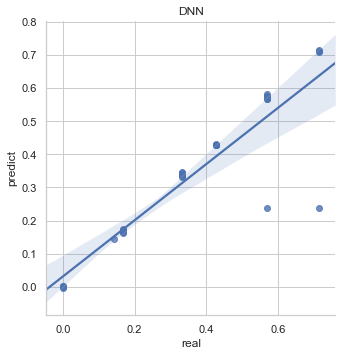

In [106]:
g = sns.lmplot(x='y_true', y='y_pred_dnn', data=uefa_pred)
plt.title('DNN')
plt.xlabel('real')
plt.ylabel('predict');

_DNN은 대부분 잘 적합되었지만, 2개 클럽은 회귀식 밖으로 튀어나갔다. 오버피팅?_

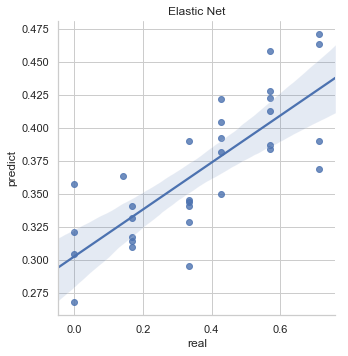

In [107]:
g = sns.lmplot(x='y_true', y='y_pred_regr', data=uefa_pred)
plt.title('Elastic Net')
plt.xlabel('real')
plt.ylabel('predict');

_반면, 회귀식은 오차는 크지만 DNN 보다는 안정적 분포를 보여준다_

마지막으로 토트넘의 우승 가능성을 살펴보자.  
함수에서 돌려주는 값은 우승 순위다. 1이면 1등, 30이면 30등!

In [143]:
def club_rank(club_name, pred_feature):
    ranks = uefa_pred[pred_feature].rank(ascending=False)
    result = pd.concat([uefa_pred['Club'], ranks], axis=1)
    return result.query("Club == '{}'".format(club_name))

In [144]:
club_rank('Tottenham Hotspur', 'y_pred_dnn')

,Club,y_pred_dnn
8,Tottenham Hotspur,13.0


In [145]:
club_rank('Tottenham Hotspur', 'y_pred_regr')

,Club,y_pred_regr
8,Tottenham Hotspur,6.0


_DNN에서는 13위, Regression에서는 6위를 예측했다._  
_Regression이 토트넘에게 후한 순위를 주었다._ 